# Lecture 4

## Generating Adversarial Examples

In preperation for this lecture we read _'Intriguing properties of neural networks, Szegedy et al. 2014_ (https://arxiv.org/pdf/1312.6199.pdf).  
Here we want to implement their method to generate adversarial examples that fool AlexNet.  
We will use PyTorch, for more information and tutorials on PyTorch checkout:  
http://pytorch.org/docs/  
http://pytorch.org/tutorials/

In [1]:
#lazy-import all the numpy and matplotlib stuff you need
%pylab inline

#some more imports
import os
cwd = os.getcwd()
from os.path import join as pj
from PIL import Image

#torch imports
import torch
from torch import optim
from torch.autograd import Variable
from torch import nn as nn
import torch.nn.functional as F

#torchvision imports
import torchvision.models as models
from torchvision import transforms

#IPython imports
from IPython import display


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:128: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the matplotlib toolkit finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
#download alexnet if you haven't done so already and placed it in the current dirctory
model_dir = pj(os.path.dirname(cwd),'Lecture2')
model_file_name = 'alexnet-owt-4df8aa71.pth'
if not os.path.exists(pj(model_dir, model_file_name)):
    !wget https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth 

In [3]:
#define alexnet architecture, load the pre-trained weights
alexnet = models.alexnet()
alexnet_weights = torch.load(pj(model_dir, model_file_name))
alexnet.load_state_dict(alexnet_weights)

#set to evaluation mode to disable Dropout
alexnet.eval()

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 1000)
  )
)

In [4]:
# define pre and post processing for images using the torchvision helper functions
img_size = 224
prep = transforms.Compose([
        transforms.Scale((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
postpa = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0],
                             std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                             std=[1,1,1]),
    ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

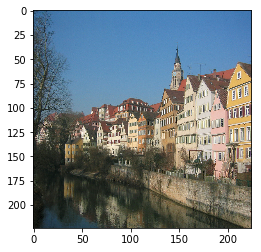

In [5]:
#get initial image
img_dir = pj(os.path.dirname(cwd), 'Lecture1')
img_name = 'Tuebingen_Neckarfront.jpg'
img = Image.open(pj(img_dir, img_name))
#preprocess image
img_torch = Variable(prep(img).unsqueeze(0), requires_grad=False)
#show preprocessed image, dimensions are now 224x224 since this is what the network was trained on
imshow(postp(img_torch.data.clone().squeeze()));show()

In [6]:
#load the list of object labels of the ImageNet Dataset that the network was trained on.
with open(pj(pj(os.path.dirname(cwd), 'Lecture1'), 'synset_words.txt')) as syn:
    class_labels = syn.readlines() 
class_labels = [label.split(' ', 1)[1].split('\n')[0] for label in class_labels]

In [7]:
#define image variable to optimise, now initialise with loaded image
opt_img = Variable(img_torch.data.clone(), requires_grad=True)

#set all the optimisation parameters
max_iter = 100 #maximum number of iterations to take
lr = 5e-1 #learning rate of the optimisation method
lam = 2e4 #weight on the L2 regularisation of the deviation from input image
optimizer = optim.SGD([opt_img], lr=lr)
target_class = 968
print('target class: ' + class_labels[target_class])

target class: cup


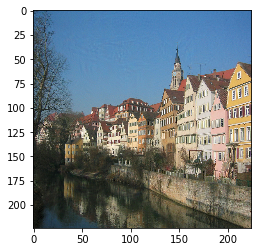

In [8]:
#run the optimisation
n_iter = 0 
while n_iter <= max_iter:
    optimizer.zero_grad()
    output = alexnet(opt_img)
    class_loss = -output[0,target_class]
    l2_loss = lam * nn.MSELoss()(opt_img, img_torch)
    loss = class_loss + l2_loss
    #print loss and show intermediate result image
    print('iter: %d, total loss: %.3f, class loss: %.3f, l2 loss: %.3f'%(n_iter, loss.data[0], class_loss.data[0], l2_loss.data[0]))
    imshow(postp(opt_img.data.clone().squeeze()))
    display.display(gcf())
    display.clear_output(wait=True)
    loss.backward()
    optimizer.step()
    n_iter +=1

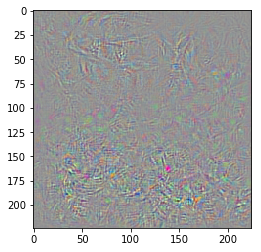

In [14]:
#show the difference image
diff_img_torch = (opt_img-img_torch)
diff_img = diff_img_torch.data.clone().squeeze().numpy().transpose(1,2,0)
diff_img -= diff_img.min()
diff_img /= diff_img.max()
imshow(diff_img)

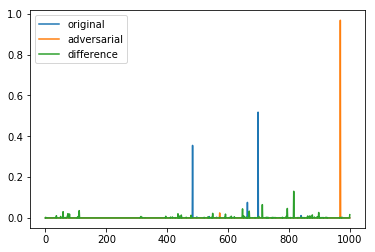

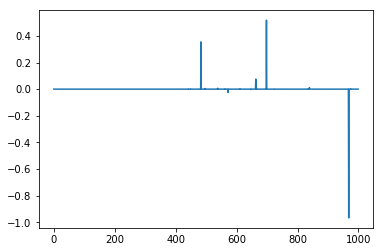

In [15]:
#classify images
out_org = F.softmax(alexnet(img_torch)).data.numpy().squeeze()
out_opt = F.softmax(alexnet(opt_img)).data.numpy().squeeze()
out_diff = F.softmax(alexnet(diff_img_torch)).data.numpy().squeeze()

#show classification 
plot(out_org)
plot(out_opt)
plot(out_diff)
gca().legend(['original','adversarial', 'difference']);show()
#show difference
plot(out_org - out_opt)

In [10]:
#show the top5 predictions for the Tuebingen image
print('original image predictions:')
[(i+1,class_labels[o], 'probability: %.2f'%(out_org[o])) for i,o in enumerate(out_org.argsort()[-5:][::-1])]

original image predictions:


[(1, 'palace', 'probability: 0.52'),
 (2, 'castle', 'probability: 0.36'),
 (3, 'monastery', 'probability: 0.08'),
 (4, 'suspension bridge', 'probability: 0.01'),
 (5, 'dome', 'probability: 0.01')]

In [11]:
print('adversarial image predictions:')
[(i+1,class_labels[o], 'probability: %.2f'%(out_opt[o])) for i,o in enumerate(out_opt.argsort()[-5:][::-1])]

adversarial image predictions:


[(1, 'cup', 'probability: 0.97'),
 (2, 'goblet', 'probability: 0.02'),
 (3, 'measuring cup', 'probability: 0.00'),
 (4, 'beer glass', 'probability: 0.00'),
 (5, 'pitcher, ewer', 'probability: 0.00')]

In [16]:
print('difference image predictions:')
[(i+1,class_labels[o], 'probability: %.2f'%(out_diff[o])) for i,o in enumerate(out_diff.argsort()[-5:][::-1])]

difference image predictions:


[(1, "spider web, spider's web", 'probability: 0.13'),
 (2, 'Petri dish', 'probability: 0.07'),
 (3, 'shower curtain', 'probability: 0.05'),
 (4, 'measuring cup', 'probability: 0.04'),
 (5, 'nematode, nematode worm, roundworm', 'probability: 0.04')]